In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img

In [2]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
def define_encoder_block(layer_in,n_filters,batchnorm=True):
    
    init=RandomNormal(stddev=0.02,seed=1)

    g=Conv2D(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
    if batchnorm:
        g=BatchNormalization()(g,training=True)
    g=LeakyReLU(alpha=0.2)(g)
    
    return g

In [4]:
def define_decoder_block(layer_in,skip_in,n_filters,dropout=True):
    
    init=RandomNormal(stddev=0.02,seed=1)

    g=Conv2DTranspose(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
    g=BatchNormalization()(g,training=True)
    if dropout:
        g=Dropout(0.5)(g,training=True)
    g=Concatenate()([g,skip_in])
    g=Activation('relu')(g)

    return g

In [5]:
def define_generator(image_shape=(256,256,3)):

    init=RandomNormal(stddev=0.02,seed=1)

    in_image=Input(shape=image_shape)

    e1=define_encoder_block(in_image,64,batchnorm=False)
    e2=define_encoder_block(e1,128)
    e3=define_encoder_block(e2,256)
    e4=define_encoder_block(e3,512)
    e5=define_encoder_block(e4,512)
    e6=define_encoder_block(e5,512)
    e7=define_encoder_block(e6,512)

    b=Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(e7)
    b=Activation('relu')(b)

    d1=define_decoder_block(b,e7,512)
    d2=define_decoder_block(d1,e6,512)
    d3=define_decoder_block(d2,e5,512)
    d4=define_decoder_block(d3,e4,512,dropout=False)
    d5=define_decoder_block(d4,e3,256,dropout=False)
    d6=define_decoder_block(d5,e2,128,dropout=False)
    d7=define_decoder_block(d6,e1,64,dropout=False)

    g=Conv2DTranspose(image_shape[2],(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d7)
    out_image=Activation('tanh')(g)

    model=Model(in_image,out_image)

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
    )

    return model

In [6]:
import os

input_x=os.listdir(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\processed_dataset\image_gan_in_final")

x_list=os.listdir(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\processed_dataset\image_post_processing_in")
y_list=os.listdir(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\processed_dataset\image_gan_out_final")

In [7]:
input_x_train=[os.path.join(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\processed_dataset\image_gan_in_final",path) for path in input_x[:70000]]
input_x_test=[os.path.join(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\processed_dataset\image_gan_in_final",path) for path in input_x[70000:]]

In [8]:
train_x=[os.path.join(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\processed_dataset\image_post_processing_in",path) for path in x_list[:70000]]
train_y=[os.path.join(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\processed_dataset\image_gan_out_final",path) for path in y_list[:70000]]

In [9]:
test_x=[os.path.join(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\processed_dataset\image_post_processing_in",path) for path in x_list[70000:]]
test_y=[os.path.join(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\processed_dataset\image_gan_out_final",path) for path in y_list[70000:]]

In [10]:
def process_path(image_path, label_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=3)
    label = tf.image.convert_image_dtype(label, tf.float32)

    return img, label

def process_path_single(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img

In [11]:
input_train_ds=tf.data.Dataset.from_tensor_slices(input_x_train)
input_train_ds=input_train_ds.map(process_path_single)
input_test_ds=tf.data.Dataset.from_tensor_slices(input_x_test)
input_test_ds=input_test_ds.map(process_path_single)

In [12]:
train_ds=tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_ds=train_ds.map(process_path)
test_ds=tf.data.Dataset.from_tensor_slices((test_x,test_y))
test_ds=test_ds.map(process_path)

In [13]:
input_train_ds=input_train_ds.batch(16)
input_test_ds=input_test_ds.batch(16)

In [14]:
train_ds=train_ds.batch(16)
test_ds=test_ds.batch(16)

In [15]:
post_model=define_generator()

In [16]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.prev_loss=0
    def on_epoch_end(self,epoch,logs={}):
        self.model.save(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/GAN Architectural Model/post_gan_results/model_{epoch}.h5")
        if(epoch>0 and logs.get('loss')>self.prev_loss):
            print('\nLearning rate updated')
            self.model.optimizer.lr.assign(self.model.optimizer.lr.read_value()*0.1)
        self.prev_loss=logs.get('loss')

callbacks=myCallback()

In [52]:
post_model.fit(train_ds,initial_epoch=5,epochs=10,callbacks=[callbacks])

Epoch 6/10
4375/4375 [==============================] - ETA: 0s - loss: 0.0033
Learning rate updated
4375/4375 [==============================] - 2022s 461ms/step - loss: 0.0033
Epoch 7/10
4375/4375 [==============================] - 2021s 462ms/step - loss: 0.0028
Epoch 8/10
4375/4375 [==============================] - 2023s 462ms/step - loss: 0.0026
Epoch 9/10
4375/4375 [==============================] - 2014s 460ms/step - loss: 0.0025
Epoch 10/10
4375/4375 [==============================] - 2032s 464ms/step - loss: 0.0024


In [53]:
# Emergency save
post_model.save(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/GAN Architectural Model/post_gan_results/model_{10}.h5")

In [17]:
post_model=tf.keras.models.load_model(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/GAN Architectural Model/post_gan_results/model_{10}.h5")

In [16]:
post_model.evaluate(test_ds)

675/675 [==============================] - 183s 241ms/step - loss: 0.0041


0.004101179540157318

In [17]:
iter=test_ds.as_numpy_iterator()
iter1=input_test_ds.as_numpy_iterator()

In [93]:
values=iter.next()
input_values=iter1.next()

In [94]:
values[0].shape,values[1].shape,input_values.shape

((16, 256, 256, 3), (16, 256, 256, 3), (16, 256, 256, 3))

In [95]:
img=post_model.predict(values[0])

1/1 [==============================] - 0s 198ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


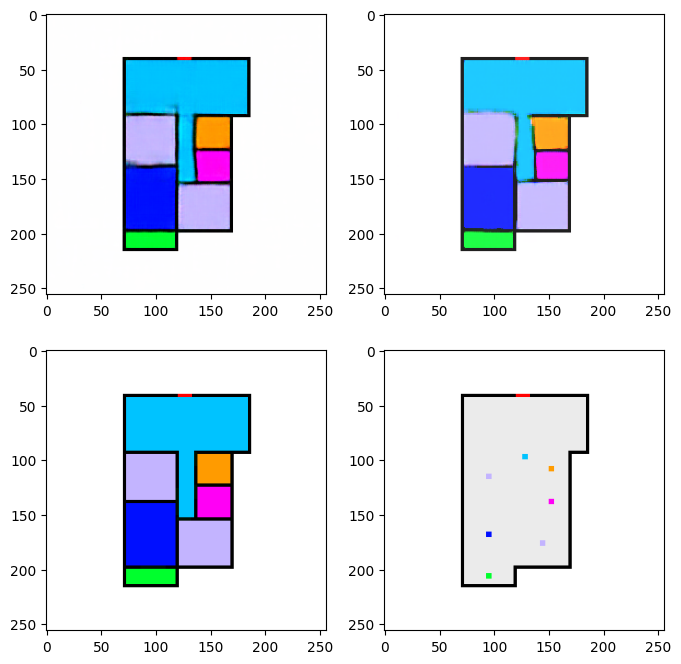

In [96]:
image=2
fig,ax=plt.subplots(2,2,figsize=(8,8))
ax[0][0].imshow(img[image])
ax[0][1].imshow(values[0][image])
ax[1][0].imshow(values[1][image])
ax[1][1].imshow(input_values[image])

In [18]:
def get_label_list(index,img):
    label_list=[]

    mask1=(img[index][:,:,0]*255<=70).astype(int)
    mask2=((img[index][:,:,1]*255<=240)*(img[index][:,:,1]*255>=150)).astype(bool).astype(int)
    mask3=(img[index][:,:,2]*255>=210).astype(int)
    living_room=mask1*mask2*mask3
    label_list.append(living_room)

    mask1=(img[index][:,:,0]*255<=70).astype(int)
    mask2=(img[index][:,:,1]*255<=70).astype(bool).astype(int)
    mask3=(img[index][:,:,2]*255>=210).astype(int)
    master_room=mask1*mask2*mask3
    label_list.append(master_room)

    mask1=(img[index][:,:,0]*255>=210).astype(int)
    mask2=((img[index][:,:,1]*255<=185)*(img[index][:,:,1]*255>=125)).astype(bool).astype(int)
    mask3=(img[index][:,:,2]*255<=70).astype(int)
    kitchen=mask1*mask2*mask3
    label_list.append(kitchen)

    mask1=(img[index][:,:,0]*255>=210).astype(int)
    mask2=(img[index][:,:,1]*255<=70).astype(bool).astype(int)
    mask3=(img[index][:,:,2]*255>=200).astype(int)
    bath_room=mask1*mask2*mask3
    label_list.append(bath_room)

    mask1=(img[index][:,:,0]*255<=70).astype(int)
    mask2=((img[index][:,:,1]*255<=135)*(img[index][:,:,1]*255>=85)).astype(bool).astype(int)
    mask3=(img[index][:,:,2]*255<=70).astype(int)
    dining_room=mask1*mask2*mask3
    label_list.append(dining_room)

    mask1=(img[index][:,:,0]*255>=210).astype(int)
    mask2=((img[index][:,:,1]*255<=230)*(img[index][:,:,1]*255>=170)).astype(bool).astype(int)
    mask3=((img[index][:,:,2]*255>=185)*(img[index][:,:,2]*255<=245)).astype(int)
    child_room=mask1*mask2*mask3
    label_list.append(child_room)

    mask1=((img[index][:,:,0]*255<=210)*(img[index][:,:,0]*255>=155)).astype(int)
    mask2=((img[index][:,:,1]*255<=130)*(img[index][:,:,1]*255>=70)).astype(bool).astype(int)
    mask3=(img[index][:,:,2]*255>=210).astype(int)
    study_room=mask1*mask2*mask3
    label_list.append(study_room)

    mask1=((img[index][:,:,0]*255<=220)*(img[index][:,:,0]*255>=165)).astype(int)
    mask2=((img[index][:,:,1]*255<=200)*(img[index][:,:,1]*255>=160)).astype(bool).astype(int)
    mask3=(img[index][:,:,2]*255>=210).astype(int)
    second_room=mask1*mask2*mask3
    label_list.append(second_room)

    mask1=((img[index][:,:,0]*255<=220)*(img[index][:,:,0]*255>=160)).astype(int)
    mask2=(img[index][:,:,1]*255>=230).astype(bool).astype(int)
    mask3=((img[index][:,:,2]*255>=65)*(img[index][:,:,2]*255>=115)).astype(int)
    guest_room=mask1*mask2*mask3
    label_list.append(guest_room)

    mask1=(img[index][:,:,0]*255<=70).astype(int)
    mask2=(img[index][:,:,1]*255>=240).astype(bool).astype(int)
    mask3=((img[index][:,:,2]*255<=65)*(img[index][:,:,2]*255>=15)).astype(int)
    balcony=mask1*mask2*mask3
    label_list.append(balcony)

    mask1=((img[index][:,:,0]*255<=145)*(img[index][:,:,0]*255>=85)).astype(int)
    mask2=(img[index][:,:,1]*255>=240).astype(bool).astype(int)
    mask3=((img[index][:,:,2]*255>=190)*(img[index][:,:,2]*255<=230)).astype(int)
    entrance=mask1*mask2*mask3
    label_list.append(entrance)

    mask1=((img[index][:,:,0]*255<=205)*(img[index][:,:,0]*255>=155)).astype(int)
    mask2=((img[index][:,:,1]*255<=140)*(img[index][:,:,1]*255>=80)).astype(bool).astype(int)
    mask3=(img[index][:,:,2]*255<=70).astype(int)
    storage=mask1*mask2*mask3
    label_list.append(storage)

    mask1=((img[index][:,:,0]*255<=240)*(img[index][:,:,0]*255>=170)).astype(int)
    mask2=(img[index][:,:,1]*255>=205).astype(bool).astype(int)
    mask3=(img[index][:,:,2]*255>=240).astype(int)
    wall_in=mask1*mask2*mask3
    label_list.append(wall_in)

    mask1=(img[index][:,:,0]*255>=240).astype(int)
    mask2=(img[index][:,:,1]*255>=240).astype(bool).astype(int)
    mask3=(img[index][:,:,2]*255>=240).astype(int)
    external_area=mask1*mask2*mask3
    label_list.append(external_area)

    mask1=(img[index][:,:,0]*255<=70).astype(int)
    mask2=(img[index][:,:,1]*255<=70).astype(bool).astype(int)
    mask3=(img[index][:,:,2]*255<=70).astype(int)
    exterior_wall=mask1*mask2*mask3
    label_list.append(exterior_wall)

    mask1=(img[index][:,:,0]*255>=240).astype(int)
    mask2=(img[index][:,:,1]*255<=70).astype(bool).astype(int)
    mask3=(img[index][:,:,2]*255<=70).astype(int)
    front_door=mask1*mask2*mask3
    label_list.append(front_door)

    mask1=(img[index][:,:,0]*255<=70).astype(int)
    mask2=(img[index][:,:,1]*255<=70).astype(bool).astype(int)
    mask3=(img[index][:,:,2]*255<=70).astype(int)
    interior_wall=mask1*mask2*mask3
    label_list.append(interior_wall)

    mask1=(img[index][:,:,0]*255>=240).astype(int)
    mask2=(img[index][:,:,1]*255>=240).astype(bool).astype(int)
    mask3=(img[index][:,:,2]*255<=70).astype(int)
    interior_door=mask1*mask2*mask3
    label_list.append(interior_door)

    return label_list

In [19]:
filter=np.array([
    [0,-1,-1,-1,0],
    [-2,2,0,2,-2],
    [0,1,1,1,0],
]).reshape(3,5,1)

filter_t=np.array([
    [0,-2,0],
    [1,2,-1],
    [1,0,-1],
    [1,2,-1],
    [0,-2,0],
]).reshape(5,3,1)

filter_lr=np.array([
    [1,0,1],
]).reshape(1,3,1)

filter_td=np.array([
    [1],
    [0],
    [1],
]).reshape(3,1,1)

filter_s=np.array([
    [-1,1,1,1,-1],
    [0,0,0,0,0],
    [-1,1,1,1,-1],
]).reshape(3,5,1)

filter_st=np.array([
    [-1,0,-1],
    [1,0,1],
    [1,0,1],
    [1,0,1],
    [-1,0,-1],
]).reshape(5,3,1)

filter_ft=np.array([
    [0,1,0],
    [1,0,1],
    [0,1,0],
]).reshape(3,3,1)

filter_ftm=np.array([
    [0,1,0],
    [1,-3,1],
    [0,1,0],
]).reshape(3,3,1)

filter_fm=np.array([
    [-1,-1,-1],
    [-1,9,-1],
    [-1,-1,-1],
]).reshape(3,3,1)

filter_p=np.array([
    [-1,-1,-1],
    [0,1,0],
    [-1,-1,-1],
]).reshape(3,3,1)

filter_pt=np.array([
    [-1,0,-1],
    [-1,1,-1],
    [-1,0,-1],
]).reshape(3,3,1)

filter_c=np.array([
    [-1,1,-1],
    [1,1,1],
    [-1,1,-1],
]).reshape(3,3,1)

filter_ct=np.array([
    [0,1,1],
    [-1,0,1],
    [-1,-1,0],
]).reshape(3,3,1)

filter_ctt=np.array([
    [1,1,-1],
    [1,3,-1],
    [-1,-1,-1],
]).reshape(3,3,1)


In [20]:
def res(value):
    return 1 if value>=4 else 0
def filter(value):
    return value if value!=0 else 255
def filter_reverse(value):
    return value if value!=255 else 0

In [21]:
def get_vectors(image):
    val=image
    rev_val_i=np.flip(val,axis=1)
    rev_val_j=np.flip(val,axis=0)

    larmin=np.argmax(val,axis=1)
    func=np.vectorize(filter)
    larmin=func(larmin)

    rarmin=255-np.argmax(rev_val_i,axis=1)
    func=np.vectorize(filter_reverse)
    rarmin=func(rarmin)

    tarmin=np.argmax(val,axis=0)
    func=np.vectorize(filter)
    tarmin=func(tarmin)

    barmin=255-np.argmax(rev_val_j,axis=0)
    func=np.vectorize(filter_reverse)
    barmin=func(barmin)

    l=0
    for i in range(len(larmin)):
        if(larmin[i]==255):
            continue
        else:
            if(tf.math.abs(larmin[i]-l)>=13):
                l=larmin[i+5]
            larmin[i]=l

    r=255
    for i in range(len(rarmin)):
        if(rarmin[i]==0):
            continue
        else:
            if(tf.math.abs(rarmin[i]-r)>=13):
                r=rarmin[i+5]
            rarmin[i]=r

    t=0
    for i in range(len(tarmin)):
        if(tarmin[i]==255):
            continue
        else:
            if(tf.math.abs(tarmin[i]-t)>=13):
                t=tarmin[i+5]
            tarmin[i]=t

    b=255
    for i in range(len(barmin)):
        if(barmin[i]==0):
            continue
        else:
            if(tf.math.abs(barmin[i]-b)>=13):
                b=barmin[i+5]
            barmin[i]=b

    # larmin.shape,rarmin.shape,tarmin.T.shape,barmin.T.shape
    return larmin,rarmin,tarmin,barmin    

In [22]:
def post_process_image(black,advanced=True,border_padding_takeaway=0):

    new_img=black.reshape(-1,256,256,1)

    if advanced:
        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_lr.reshape(1,3,1,1),strides=(1,1),padding='SAME')
        new_img=(new_img.numpy()>0).astype(int)
        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_td.reshape(3,1,1,1),strides=(1,1),padding='SAME')
        new_img=(new_img.numpy()>0).astype(int)
        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_s.reshape(3,5,1,1),strides=(1,1),padding='SAME')
        new_img=(new_img.numpy()>0).astype(int)
        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_st.reshape(5,3,1,1),strides=(1,1),padding='SAME')
        new_img=(new_img.numpy()>0).astype(int)
        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_ft.reshape(3,3,1,1),strides=(1,1),padding='SAME')
        new_img=(((new_img.numpy()==4)+(new_img.numpy()==3)+(new_img.numpy()==2))>0).astype(int)
        semi_bench=new_img

        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_lr.reshape(1,3,1,1),strides=(1,1),padding='SAME')
        new_img=(new_img.numpy()>0).astype(int)
        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_td.reshape(3,1,1,1),strides=(1,1),padding='SAME')
        new_img=(new_img.numpy()>0).astype(int)
        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_s.reshape(3,5,1,1),strides=(1,1),padding='SAME')
        new_img=(new_img.numpy()>0).astype(int)
        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_st.reshape(5,3,1,1),strides=(1,1),padding='SAME')
        new_img=(new_img.numpy()>0).astype(int)
        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_ft.reshape(3,3,1,1),strides=(1,1),padding='SAME')
        new_img=(((new_img.numpy()==4)+(new_img.numpy()==3)+(new_img.numpy()==2))>0).astype(int)

        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_lr.reshape(1,3,1,1),strides=(1,1),padding='SAME')
        new_img=(new_img.numpy()>0).astype(int)
        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_td.reshape(3,1,1,1),strides=(1,1),padding='SAME')
        new_img=(new_img.numpy()>0).astype(int)
        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_s.reshape(3,5,1,1),strides=(1,1),padding='SAME')
        new_img=(new_img.numpy()>0).astype(int)
        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_st.reshape(5,3,1,1),strides=(1,1),padding='SAME')
        new_img=(new_img.numpy()>0).astype(int)
        new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_ft.reshape(3,3,1,1),strides=(1,1),padding='SAME')
        new_img=(((new_img.numpy()==4)+(new_img.numpy()==3)+(new_img.numpy()==2))>0).astype(int)

        bench=new_img

        # plt.imshow((new_img[0])*255,cmap='gray')

        new_img=bench

        for i in range(10):
            new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_p.reshape(3,3,1,1),strides=(1,1),padding='SAME')
            new_img=(new_img.numpy()==-5).astype(int)
            new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_pt.reshape(3,3,1,1),strides=(1,1),padding='SAME')
            new_img=(new_img.numpy()==-5).astype(int)
            new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_ft.reshape(3,3,1,1),strides=(1,1),padding='SAME')
            new_img=(new_img.numpy()==4).astype(int)

            new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_p.reshape(3,3,1,1)*-1,strides=(1,1),padding='SAME')
            new_img=(new_img.numpy()>0).astype(int)
            new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_pt.reshape(3,3,1,1)*-1,strides=(1,1),padding='SAME')
            new_img=(new_img.numpy()>0).astype(int)
            new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_ft.reshape(3,3,1,1),strides=(1,1),padding='SAME')
            new_img=(((new_img.numpy()==4)+(new_img.numpy()==3)+(new_img.numpy()==2))>0).astype(int)

            new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_c.reshape(3,3,1,1)*-1,strides=(1,1),padding='SAME')
            new_img=(new_img.numpy()<0).astype(int)
            new_img=tf.nn.conv2d(new_img.reshape(-1,256,256,1),filter_c.reshape(3,3,1,1)*-1,strides=(1,1),padding='SAME')
            new_img=(new_img.numpy()<0).astype(int)

    # plt.imshow(bench[0]*255,cmap="gray")

    larmin,rarmin,tarmin,barmin=get_vectors(new_img[0])

    if not advanced:
        larmin,rarmin,tarmin,barmin=larmin+border_padding_takeaway,rarmin-border_padding_takeaway,tarmin+border_padding_takeaway,barmin-border_padding_takeaway

    i_=np.fromfunction(lambda i,j: i,(256,256))
    j_=np.fromfunction(lambda i,j: j,(256,256))

    mask1=(j_>larmin).astype(int)
    mask2=(j_<rarmin).astype(int)
    mask3=(i_>tarmin.T).astype(int)
    mask4=(i_<barmin.T).astype(int)

    result=mask1+mask2+mask3+mask4
    func=np.vectorize(res)
    result=func(result)
    result=result.reshape(256,256,1)

    return result

In [23]:
color=[
    np.array([0,195,255]),      # living room       # #00c3ff
    np.array([0,15,255]),       # master room       # #000fff
    np.array([255,155,0]),      # kitchen           # #ff9b00
    np.array([255,0,245]),      # bathroom          # #ff00f5
    np.array([0,115,25]),       # dining room       # #007319
    np.array([255,200,215]),    # child room        # #ffc8d7
    np.array([185,100,255]),    # study room        # #b964ff
    np.array([195,180,255]),    # Second room       # #c3b4ff
    np.array([190,245,95]),     # guest room        # #bef55f
    np.array([0,255,45]),       # Balcony           # #00ff2d
    np.array([115,255,215]),    # Entrance          # #73ffd7
    np.array([180,110,50]),     # Storage           # #b46e32
    np.array([200,235,255]),    # Wall-in           # #c8ebff
    np.array([255,255,255]),    # External area     # #ffffff
    np.array([0,0,0]),          # Exterior Wall     # #000000
    np.array([255,0,0]),        # Front door        # #ff0000
    np.array([0,0,0]),          # Interior wall     # #000000
    np.array([255,255,0])       # interior door     # #ffff00
]

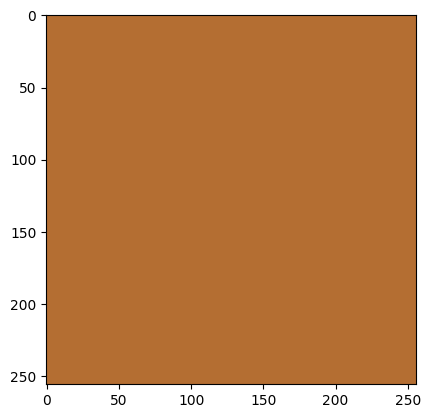

In [24]:
plt.imshow((np.ones((256,256,3))*color[11]).astype(int))

In [25]:
plt.imshow(img[0])

NameError: name 'img' is not defined

1/1 [==============================] - 0s 96ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


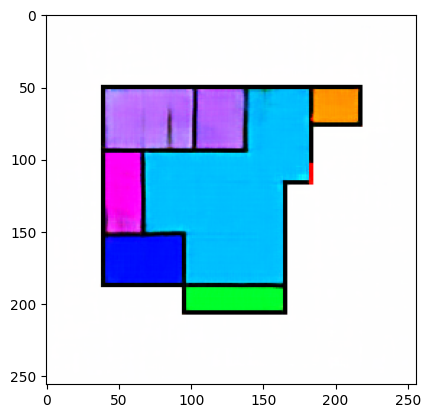

In [28]:
post_count = 10

img=np.array(load_img(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\processed_dataset\image_post_processing_in\71847.png")).reshape(1,256,256,3)/255
input_values=np.array(load_img(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\processed_dataset\image_gan_in_final\71847.png")).reshape(1,256,256,3)/255
for i in range(post_count):
    img=post_model.predict(img)
plt.imshow(img[0])

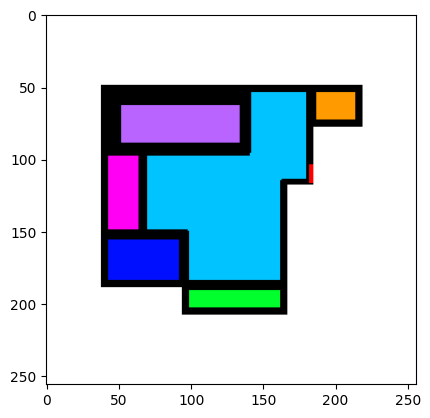

In [39]:
index=0
advanced = True
border_padding_takeaway = 2

label_list=get_label_list(index,img)

result=np.ones((256,256,3),dtype=int)*255
outside_area=(input_values[index][:,:,0]==1).astype(int).reshape(256,256,1)
result=result*outside_area
outside_walls=((input_values[index][:,:,0]*255!=0)+(input_values[index][:,:,1]*255!=0)+(input_values[index][:,:,2]*255!=0)).reshape(256,256,1)
result=result*outside_walls
not_front_door_=(((input_values[index][:,:,0]*255!=255)+(input_values[index][:,:,1]*255!=0)+(input_values[index][:,:,2]*255!=0)).reshape(256,256,1))
front_door_=(((input_values[index][:,:,0]*255>=240)*(input_values[index][:,:,1]*255==0)*(input_values[index][:,:,2]*255==0)).reshape(256,256,1))
result=result*not_front_door_+front_door_*(color[15].reshape(1,1,3))

filter_pad=np.ones((7,7))

for i,label_items in enumerate(label_list):
    if i>=13:
        break
    else:
        image=post_process_image(label_items,advanced,border_padding_takeaway)
        image=tf.nn.conv2d(image.reshape(-1,256,256,1),filter_pad.reshape(7,7,1,1),strides=(1,1),padding='SAME')
        image=(image[0].numpy()>0).astype(int)
        result=result*(image!=1)
        image=image*(color[i].reshape(1,1,3))
        result+=image        

plt.imshow(result.astype(int))